# Reproduce Seq2Vec embedding

https://www.tensorflow.org/tutorials/text/word2vec

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/skipgrams

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import shutil
import tensorflow as tf

from datetime import datetime
from pathlib import Path
from pprint import pprint
from tqdm.notebook import trange, tqdm
from tqdm.keras import TqdmCallback

from tensorflow.keras import Sequential, Model, Input, layers
from tensorflow.keras.preprocessing.sequence import pad_sequences, skipgrams
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
proc_data = Path('../data/virtifier').resolve()
seq2vec_repo = Path('../repos/seq2vec').resolve()
assert proc_data.is_dir()
assert seq2vec_repo.is_dir()

In [3]:
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

# Load Sequence Data

In [4]:
p2codon_codes = proc_data / 'seq2vec_codon2codes.json'
with open(p2codon_codes, 'r') as fp:
    codon2codes = json.load(fp)
code2codons = {i:c for c, i in codon2codes.items()}

In [5]:
def preprocess_fasta(fasta_path, window=3, mode='both', max_nbr_seq=None):
    """Preprocess sequence from fasta file into a sequence of codons, with window size
    
    Return:
        sequences as a list of encoded sequences
    """
    # Validate parameters
    if mode not in ['encoded', 'literal', 'both']:
        raise ValueError(f"mode should be either 'literal' or 'encoded', not '{mode}'")

    if isinstance(fasta_path, str):
        fasta_path = Path(fasta_path)
    elif not isinstance(fasta_path, Path):
        raise TypeError(f"fasta_path must be a string or a Path, not {fasta_path}: {type(fasta_path)}")

    sequences_literal = []
    sequences_encoded = []
    with open(fasta_path, 'r') as fp:
        line_nbr = 0
        # Read fasta file line by line
        while True:
            line = fp.readline()
            # EOF
            if line == '':
                break
            # Early Exit
            elif max_nbr_seq is not None and  line_nbr >= max_nbr_seq:
                break
            # Fasta Comment Line
            elif line.startswith('>'):
                continue
            # Fasta Sequence Line
            else:
                line_nbr += 1
                sequence_literal = []
                sequence_encoded = []
                line_lentgh = len(line) - 1
                for i in range(0, line_lentgh-window+1):
                # for i in range(0, 5):
                    codon_literal = line[i:i+window]
                    codon_encoded = codon2codes[codon_literal]
                    sequence_literal.append(codon_literal)
                    sequence_encoded.append(codon_encoded)
                sequences_literal.append(sequence_literal)
                sequences_encoded.append(sequence_encoded)
        if mode == 'literal':
            return sequences_literal
        elif mode == 'encoded':
            return sequences_encoded
        elif mode == 'both':
            return sequences_literal, sequences_encoded
        else:
            pass


p2fasta = proc_data / 'training_sequences_300bp.fasta'

sequences, encoded = preprocess_fasta(p2fasta, mode='both', max_nbr_seq=20)
assert len(sequences) == len(encoded)
len(encoded)

20

# Generate skip-grams from one sequence

### Positive Samples

In [5]:
seq_nbr = 0
window_size = 1
vocab_size = len(code2codons)

positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
      encoded[seq_nbr],
      vocabulary_size=vocab_size,
      window_size=window_size,
      shuffle=False,
      negative_samples=0)

print(len(positive_skip_grams))

594


Print a few positive skip-grams:

In [6]:
print(' '.join([f"{c}" for c in sequences[seq_nbr][:10]]))
print(' '.join([f"{c:2d} " for c in encoded[seq_nbr][:10]]))

for target, context in positive_skip_grams[:5]:
  print(f"({target:2d},{context:2d}) : ({code2codons[target]},{code2codons[context]})")

TGT GTC TCT CTA TAT ATT TTC TCT CTA TAT
46  57  35  61  16   6   9  35  61  16 
(46,57) : (TGT,GTC)
(57,46) : (GTC,TGT)
(57,35) : (GTC,TCT)
(35,57) : (TCT,GTC)
(35,61) : (TCT,CTA)


### Negative sampling for one skip-gram 

The `skipgrams` function returns all positive skip-gram pairs by sliding over a given window span. To produce additional skip-gram pairs that would serve as negative samples for training, you need to sample random words from the vocabulary. Use the `tf.random.log_uniform_candidate_sampler` function to sample `num_ns` number of negative samples for a given target word in a window. You can call the function on one skip-grams's target word and pass the context word as true class to exclude it from being sampled.


Key point: `num_ns` (the number of negative samples per a positive context word) in the `[5, 20]` range is [shown to work](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) best for smaller datasets, while `num_ns` in the `[2, 5]` range suffices for larger datasets.

In [7]:
# tf.random.log_uniform_candidate_sampler?

In [8]:
# Get target and context words for one positive skip-gram.
target_codon, context_codon = positive_skip_grams[0]
print(target_codon, code2codons[target_codon])
print(context_codon, code2codons[context_codon])

# Set the number of negative samples per positive context.
num_ns = 4

context_class = tf.reshape(tf.constant(context_codon, dtype="int64"), (1, 1))
print(context_class.shape)
print(context_class)

negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
    true_classes=context_class,  # class that should be sampled as 'positive'
    num_true=1,  # each positive skip-gram has 1 positive context class
    num_sampled=num_ns,  # number of negative context words to sample
    unique=True,  # all the negative samples should be unique
    range_max=vocab_size,  # pick index of the samples from [0, vocab_size]
    seed=SEED,  # seed for reproducibility
    name="negative_sampling"  # name of this operation
)
print(negative_sampling_candidates.shape)
print(negative_sampling_candidates.numpy())
print([code2codons[index.numpy()] for index in negative_sampling_candidates])

46 TGT
57 GTC
(1, 1)
tf.Tensor([[57]], shape=(1, 1), dtype=int64)


2022-08-25 14:27:24.379372: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-25 14:27:24.395440: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


(4,)
[12  3 28  6]
['AAC', 'GAA', 'GGT', 'ATT']


### Construct one training example

For a given positive `(target_word, context_word)` skip-gram, you now also have `num_ns` negative sampled context words that do not appear in the window size neighborhood of `target_word`. Batch the `1` positive `context_word` and `num_ns` negative context words into one tensor. This produces a set of positive skip-grams (labeled as `1`) and negative samples (labeled as `0`) for each target word.

In [9]:
# Add a dimension so you can use concatenation (in the next step).
negative_sampling_candidates = tf.expand_dims(negative_sampling_candidates, 1)

# Concatenate a positive context word with negative sampled words.
context = tf.concat([context_class, negative_sampling_candidates], axis=0)

# Label the first context word as `1` (positive) followed by `num_ns` `0`s (negative).
label = tf.constant([1] + [0]*num_ns, dtype="int64")

# Reshape the target to shape `(1,)` and context and label to `(num_ns+1,)`.
target = tf.squeeze(target_codon)
context = tf.squeeze(context)
label = tf.squeeze(label)

print('target batch  : ', target)
print('context batch : ', context) 
print('context labels: ', label)

target batch  :  tf.Tensor(46, shape=(), dtype=int32)
context batch :  tf.Tensor([57 12  3 28  6], shape=(5,), dtype=int64)
context labels:  tf.Tensor([1 0 0 0 0], shape=(5,), dtype=int64)


Check out the context and the corresponding labels for the target word from the skip-gram example above:

In [10]:
print(f"target_index    : {target}")
print(f"target codon    : {code2codons[target_codon]}")
print(f"context_indices : {context}")
print(f"context codons  : {[code2codons[c.numpy()] for c in context]}")
print(f"label           : {label}")

target_index    : 46
target codon    : TGT
context_indices : [57 12  3 28  6]
context codons  : ['GTC', 'AAC', 'GAA', 'GGT', 'ATT']
label           : [1 0 0 0 0]


A tuple of `(target, context, label)` tensors constitutes one training example for training your skip-gram negative sampling word2vec model. Notice that the target is of shape `(1,)` while the context and label are of shape `(1+num_ns,)`

In [11]:
print("target  :", target)
print("context :", context)
print("label   :", label)

target  : tf.Tensor(46, shape=(), dtype=int32)
context : tf.Tensor([57 12  3 28  6], shape=(5,), dtype=int64)
label   : tf.Tensor([1 0 0 0 0], shape=(5,), dtype=int64)


### Compile all steps into one function


#### Skip-gram sampling table 

A large dataset means larger vocabulary with higher number of more frequent words such as stopwords. Training examples obtained from sampling commonly occurring words (such as `the`, `is`, `on`) don't add much useful information  for the model to learn from. [Mikolov et al.](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) suggest subsampling of frequent words as a helpful practice to improve embedding quality. 

The `tf.keras.preprocessing.sequence.skipgrams` function accepts a sampling table argument to encode probabilities of sampling any token. You can use the `tf.keras.preprocessing.sequence.make_sampling_table` to  generate a word-frequency rank based probabilistic sampling table and pass it to the `skipgrams` function. Inspect the sampling probabilities for a `vocab_size` of 10.

In [12]:
sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(size=65)
print(', '.join([f"{s:.3e}" for s in sampling_table]))

3.152e-03, 3.152e-03, 5.476e-03, 7.416e-03, 9.128e-03, 1.068e-02, 1.212e-02, 1.347e-02, 1.474e-02, 1.596e-02, 1.711e-02, 1.823e-02, 1.930e-02, 2.033e-02, 2.134e-02, 2.231e-02, 2.326e-02, 2.418e-02, 2.508e-02, 2.596e-02, 2.682e-02, 2.767e-02, 2.849e-02, 2.931e-02, 3.010e-02, 3.089e-02, 3.166e-02, 3.241e-02, 3.316e-02, 3.389e-02, 3.462e-02, 3.533e-02, 3.604e-02, 3.673e-02, 3.742e-02, 3.810e-02, 3.877e-02, 3.943e-02, 4.008e-02, 4.073e-02, 4.137e-02, 4.200e-02, 4.263e-02, 4.325e-02, 4.386e-02, 4.447e-02, 4.507e-02, 4.567e-02, 4.626e-02, 4.685e-02, 4.743e-02, 4.801e-02, 4.858e-02, 4.914e-02, 4.971e-02, 5.026e-02, 5.082e-02, 5.137e-02, 5.191e-02, 5.245e-02, 5.299e-02, 5.352e-02, 5.405e-02, 5.458e-02, 5.510e-02


`sampling_table[i]` denotes the probability of sampling the i-th most common word in a dataset. The function assumes a [Zipf's distribution](https://en.wikipedia.org/wiki/Zipf%27s_law) of the word frequencies for sampling.

Key point: The `tf.random.log_uniform_candidate_sampler` already assumes that the vocabulary frequency follows a log-uniform (Zipf's) distribution. Using these distribution weighted sampling also helps approximate the Noise Contrastive Estimation (NCE) loss with simpler loss functions for training a negative sampling objective.

### Generate training data

Compile all the steps described above into a function that can be called on a list of vectorized sentences obtained from any text dataset. Notice that the sampling table is built before sampling skip-gram word pairs. You will use this function in the later sections.

In [13]:
# Generates skip-gram pairs with negative sampling for a list of sequences
# (int-encoded sentences) based on window size, number of negative samples
# and vocabulary size.
def generate_training_data(sequences, window_size, num_ns, vocab_size, seed):
  # Elements of each training example are appended to these lists.
  targets, contexts, labels = [], [], []

  # Build the sampling table for `vocab_size` tokens.
  sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)

  # Iterate over all sequences (sentences) in the dataset.
  for sequence in tqdm(sequences):

    # Generate positive skip-gram pairs for a sequence (sentence).
    positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
          sequence,
          vocabulary_size=vocab_size,
          sampling_table=sampling_table,
          window_size=window_size,
          negative_samples=0)

    # Iterate over each positive skip-gram pair to produce training examples
    # with a positive context word and negative samples.
    for target_word, context_word in positive_skip_grams:
      context_class = tf.expand_dims(
          tf.constant([context_word], dtype="int64"), 1)
      negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
          true_classes=context_class,
          num_true=1,
          num_sampled=num_ns,
          unique=True,
          range_max=vocab_size,
          seed=seed,
          name="negative_sampling")

      # Build context and label vectors (for one target word)
      negative_sampling_candidates = tf.expand_dims(
          negative_sampling_candidates, 1)

      context = tf.concat([context_class, negative_sampling_candidates], axis=0)
      label = tf.constant([1] + [0]*num_ns, dtype="int64")

      # Append each element from the training example to global lists.
      targets.append(target_word)
      contexts.append(context)
      labels.append(label)

  return targets, contexts, labels

t, c, l = generate_training_data(encoded, window_size=1, num_ns=4, vocab_size=vocab_size, seed=SEED)

  0%|          | 0/20 [00:00<?, ?it/s]

# Prepare training data for Seq2Vec

## Obtain sequences from the dataset

In [14]:
max_nbr_seq = None

sequences, encoded = preprocess_fasta(p2fasta, mode='both', max_nbr_seq=max_nbr_seq)
len(sequences)

9000

Inspect a few examples from `sequences`:

In [15]:
for seq in encoded[:3]:
  print(f"{seq} => {[code2codons[i] for i in seq[:10]]}")

[46, 57, 35, 61, 16, 6, 9, 35, 61, 16, 6, 14, 16, 21, 16, 6, 14, 16, 21, 16, 21, 63, 10, 40, 44, 39, 45, 11, 6, 14, 63, 49, 57, 35, 60, 15, 7, 1, 12, 37, 59, 24, 2, 20, 8, 11, 21, 16, 6, 14, 13, 1, 1, 4, 54, 28, 22, 2, 20, 8, 51, 49, 22, 2, 2, 2, 2, 14, 16, 6, 2, 2, 2, 14, 16, 19, 35, 61, 13, 12, 25, 7, 5, 21, 63, 10, 3, 5, 6, 14, 13, 12, 25, 26, 10, 51, 49, 22, 2, 2, 2, 14, 13, 12, 25, 26, 10, 51, 49, 22, 9, 35, 61, 16, 6, 2, 2, 14, 13, 1, 1, 4, 49, 22, 20, 18, 29, 30, 31, 21, 48, 47, 24, 14, 63, 49, 52, 13, 1, 5, 21, 63, 49, 22, 9, 15, 7, 4, 38, 34, 60, 35, 24, 2, 14, 16, 6, 9, 35, 24, 9, 35, 24, 2, 2, 9, 36, 39, 62, 29, 34, 60, 15, 7, 4, 10, 11, 17, 46, 53, 8, 51, 49, 52, 16, 21, 63, 54, 28, 57, 58, 42, 31, 21, 63, 49, 57, 15, 7, 5, 6, 20, 43, 30, 7, 12, 47, 24, 2, 20, 8, 3, 5, 17, 8, 40, 37, 59, 61, 63, 38, 50, 59, 24, 2, 9, 35, 24, 20, 8, 3, 5, 19, 15, 56, 47, 24, 2, 14, 16, 21, 13, 12, 47, 60, 15, 31, 6, 2, 9, 15, 26, 38, 30, 31, 6, 2, 14, 13, 1, 12, 25, 7, 1, 4, 54, 29, 34, 61, 

## Generate training examples from sequences

`sequences` is now a list of int encoded sentences. Just call the `generate_training_data` function defined earlier to generate training examples for the word2vec model. To recap, the function iterates over each word from each sequence to collect positive and negative context words. Length of target, contexts and labels should be the same, representing the total number of training examples.

In [16]:
targets, contexts, labels = generate_training_data(
    sequences=encoded,
    window_size=2,
    num_ns=4,
    vocab_size=vocab_size,
    seed=SEED)

targets = np.array(targets)
contexts = np.array(contexts)[:,:,0]
labels = np.array(labels)

print('\n')
print(f"targets.shape: {targets.shape}")
print(f"contexts.shape: {contexts.shape}")
print(f"labels.shape: {labels.shape}")

  0%|          | 0/9000 [00:00<?, ?it/s]



targets.shape: (305852,)
contexts.shape: (305852, 5)
labels.shape: (305852, 5)


In [17]:
targets[:10]

array([26,  7, 61,  9, 39, 61,  9, 39, 26,  9])

In [18]:
contexts[:10, :]

array([[10,  1,  7,  3,  5],
       [ 4, 13,  1, 22,  4],
       [12,  5, 44,  0,  6],
       [61, 15, 49, 10, 14],
       [ 9,  5, 23, 11,  1],
       [19, 24,  0,  6, 38],
       [22,  3, 59, 18, 10],
       [36,  0,  2,  1,  9],
       [51,  0, 10, 19,  3],
       [35, 41, 16,  7, 38]])

In [19]:
labels[:10, :]

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]])

## Configure the dataset for performance

To perform efficient batching for the potentially large number of training examples, use the `tf.data.Dataset` API. After this step, you would have a `tf.data.Dataset` object of `(target_word, context_word), (label)` elements to train your word2vec model!

In [20]:
BATCH_SIZE = 1024
BUFFER_SIZE = 10_000

dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

print(dataset)
dataset.element_spec

<BatchDataset element_spec=((TensorSpec(shape=(1024,), dtype=tf.int64, name=None), TensorSpec(shape=(1024, 5), dtype=tf.int64, name=None)), TensorSpec(shape=(1024, 5), dtype=tf.int64, name=None))>


((TensorSpec(shape=(1024,), dtype=tf.int64, name=None),
  TensorSpec(shape=(1024, 5), dtype=tf.int64, name=None)),
 TensorSpec(shape=(1024, 5), dtype=tf.int64, name=None))

Apply `Dataset.cache` and `Dataset.prefetch` to improve performance:

In [21]:
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(1024,), dtype=tf.int64, name=None), TensorSpec(shape=(1024, 5), dtype=tf.int64, name=None)), TensorSpec(shape=(1024, 5), dtype=tf.int64, name=None))>

# Model and training

The Seq2Vec model can be implemented as a classifier to distinguish between **true context words** from skip-grams and **false context words** obtained through negative sampling. 

You can perform a dot product multiplication between the embeddings of target and context words to obtain predictions for labels and compute the loss function against true labels in the dataset.

We will use the Functional API

In [22]:
vocab_size, embedding_dim, num_ns = len(code2codons), 20, 4

In [23]:
def init_seq2vec(vocab_size=65, embedding_dim=20, num_ns=4):
    
    target_in = Input(shape=(), name='target_in')
    context_in = Input(shape=(1+num_ns), name='context_in')

    embs_target = layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=1,
        name="seq2vec_embs")(target_in)

    embs_context = layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=1+num_ns,
        name="context_embs")(context_in)

    logits = tf.einsum('be,bce->bc', embs_target, embs_context)

    seq2vec = Model([target_in, context_in], logits, name='seq2vec')

    return seq2vec

init_seq2vec(vocab_size, embedding_dim, num_ns).summary()

Model: "seq2vec"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 target_in (InputLayer)         [(None,)]            0           []                               
                                                                                                  
 context_in (InputLayer)        [(None, 5)]          0           []                               
                                                                                                  
 seq2vec_embs (Embedding)       (None, 20)           1300        ['target_in[0][0]']              
                                                                                                  
 context_embs (Embedding)       (None, 5, 20)        1300        ['context_in[0][0]']             
                                                                                            

In [24]:
vocab_size, embedding_dim, num_ns

(65, 20, 4)

## Training

In [25]:
s2v = init_seq2vec(vocab_size, embedding_dim, num_ns)

opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

s2v.compile(
    optimizer=opt,
    loss=loss,
    metrics=['accuracy']
)

In [ ]:
es = EarlyStopping(patience=10, monitor='loss', restore_best_weights=True, min_delta=1e-4)
pb = TqdmCallback(verbose=1)

hist = s2v.fit(
    dataset, 
    epochs=1000, 
    verbose=0,
    callbacks=[es, pb]
)

<AxesSubplot:>

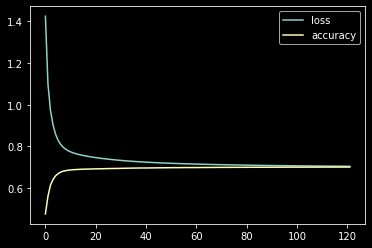

In [ ]:
pd.DataFrame(hist.history).plot()

In [34]:
fname_seed = 's2q-9000seq-300bp-window-1'
SAVE_MODEL = False
if SAVE_MODEL:
    p2saved = Path('../saved').resolve()
    timestamp = datetime.now().strftime('%Y%m%d-%H%M-UTC')
    model_fname = f"{fname_seed}-model-{timestamp}"
    weights_fname = f"{fname_seed}-weights-{timestamp}.h5"
    s2v.save(p2saved / model_fname);
    s2v.save_weights(p2saved / weights_fname);

LOAD_MODEL = True
if LOAD_MODEL:
    vocab_size, embedding_dim, num_ns = len(code2codons), 20, 4
    p2saved = Path('../saved').resolve()
    p2weights = p2saved / "s2q-9000seq-300bp-window-1-weights-20220823-1804-UTC.h5"
    assert p2weights.is_file()

    vocab_size, embedding_dim, num_ns = len(code2codons), 20, 4
    s2v = init_seq2vec(vocab_size, embedding_dim, num_ns)
    s2v.load_weights(p2weights)

    s2v.summary()

Model: "seq2vec"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 target_in (InputLayer)         [(None,)]            0           []                               
                                                                                                  
 context_in (InputLayer)        [(None, 5)]          0           []                               
                                                                                                  
 seq2vec_embs (Embedding)       (None, 20)           1300        ['target_in[0][0]']              
                                                                                                  
 context_embs (Embedding)       (None, 5, 20)        1300        ['context_in[0][0]']             
                                                                                            

# Embedding lookup and analysis

Obtain the weights from the model using `Model.get_layer` and `Layer.get_weights`. The `TextVectorization.get_vocabulary` function provides the vocabulary to build a metadata file with one token per line.

In [35]:
embeddings = s2v.get_layer('seq2vec_embs').get_weights()[0]
embeddings.shape

(65, 20)

In [36]:
codon_groups = {
    'Leucine': 'TTA CTA'.split(' '),
    'Group 2': 'CTG CTT'.split(' '),
    'Glycine': 'GGA GGC GGG GGT'.split(' '),
    'Threonine': 'ACA ACC ACG ACT'.split(' '),
    'Alanine': 'GCA GCC GCG GCT'.split(' '),
    'Proline': 'CCA CCC CCG CCT'.split(' '),
}

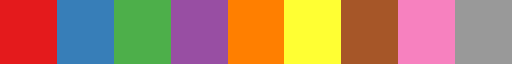

In [37]:
from matplotlib.cm import get_cmap
# cmap = get_cmap('tab10')
cmap = get_cmap('Set1')
display(cmap)
codon_group_colors = [cmap(c) for c in range(len(codon_groups))]

In [38]:
def plot_embeddings(x1, x2, title='Codon Mapping', cmap='Set1'):
    cmap = get_cmap(cmap)
    codon_group_colors = [cmap(c) for c in range(len(codon_groups))]

    plt.figure(figsize=(8,8))
    plt.scatter(x1, x2, color='white')
    plt.title(title, fontsize=20)
    for codon_group, color in zip(codon_groups.values(), codon_group_colors):
        for codon in codon_group:
            idx = codon2codes[codon]
            plt.annotate(
                codon, 
                (x1[idx], x2[idx]), 
                xytext=(2,1),
                color=color, fontsize=14, fontweight='heavy', textcoords='offset points')
    plt.axis('off')
    plt.show()

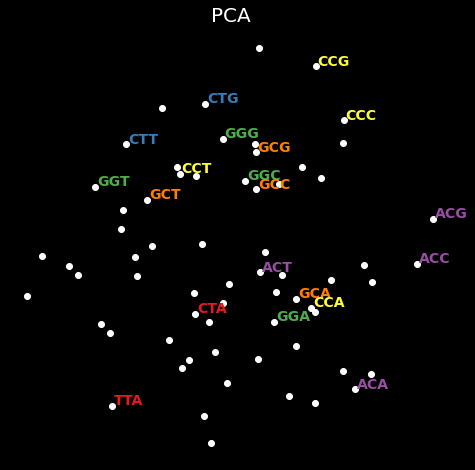

In [39]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
embs = pca.fit_transform(embeddings)

plot_embeddings(embs[:, 0], embs[:, 1], title='PCA')

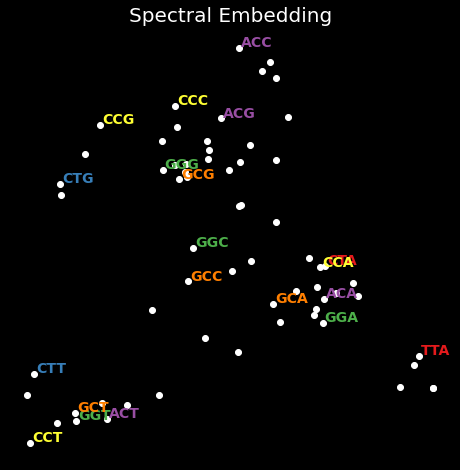

In [40]:
from sklearn.manifold import SpectralEmbedding
spectral = SpectralEmbedding(
    n_components=2,
    n_jobs=-1,
)
embs = spectral.fit_transform(embeddings)

plot_embeddings(embs[:, 0], embs[:, 1], title='Spectral Embedding')

/home/vtec/miniconda/envs/metagen/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


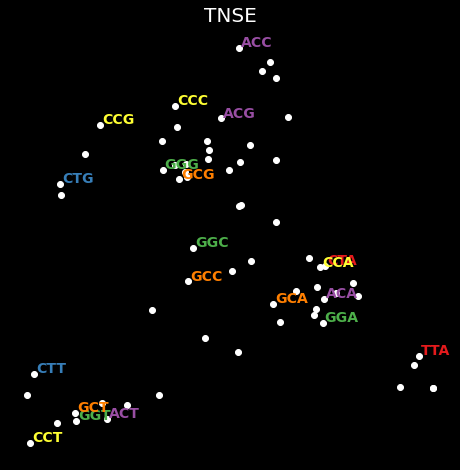

In [50]:
from sklearn.manifold import TSNE
tsne = TSNE(
    n_components=2,
    perplexity=30.0, 
    early_exaggeration=12.0,
    learning_rate='auto',
    n_iter=1000,
    init='pca',
    metric='euclidean',
    n_jobs=-1
    )

tsne_embs = tsne.fit_transform(embeddings)

plot_embeddings(embs[:, 0], embs[:, 1], title='TNSE')

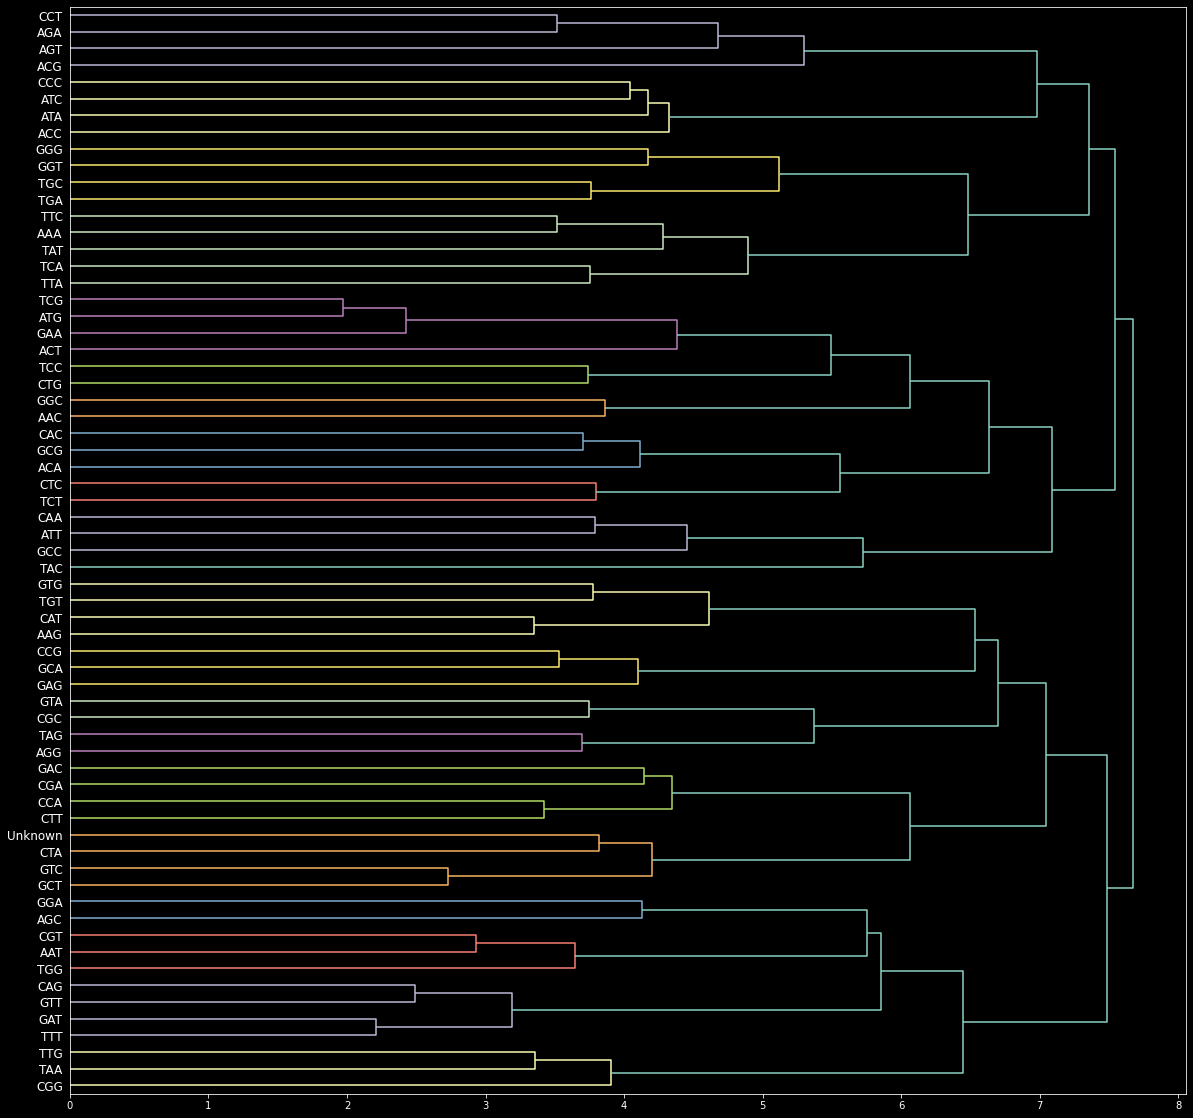

In [44]:
from scipy.spatial.distance import pdist, cosine
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(embeddings, method='complete', metric='euclidean')
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
labels = list(codon2codes.keys())
dn = dendrogram(
    Z, 
    truncate_mode=None, 
    orientation='right', 
    labels=labels, leaf_font_size=12,
    ax=ax
)
plt.show()

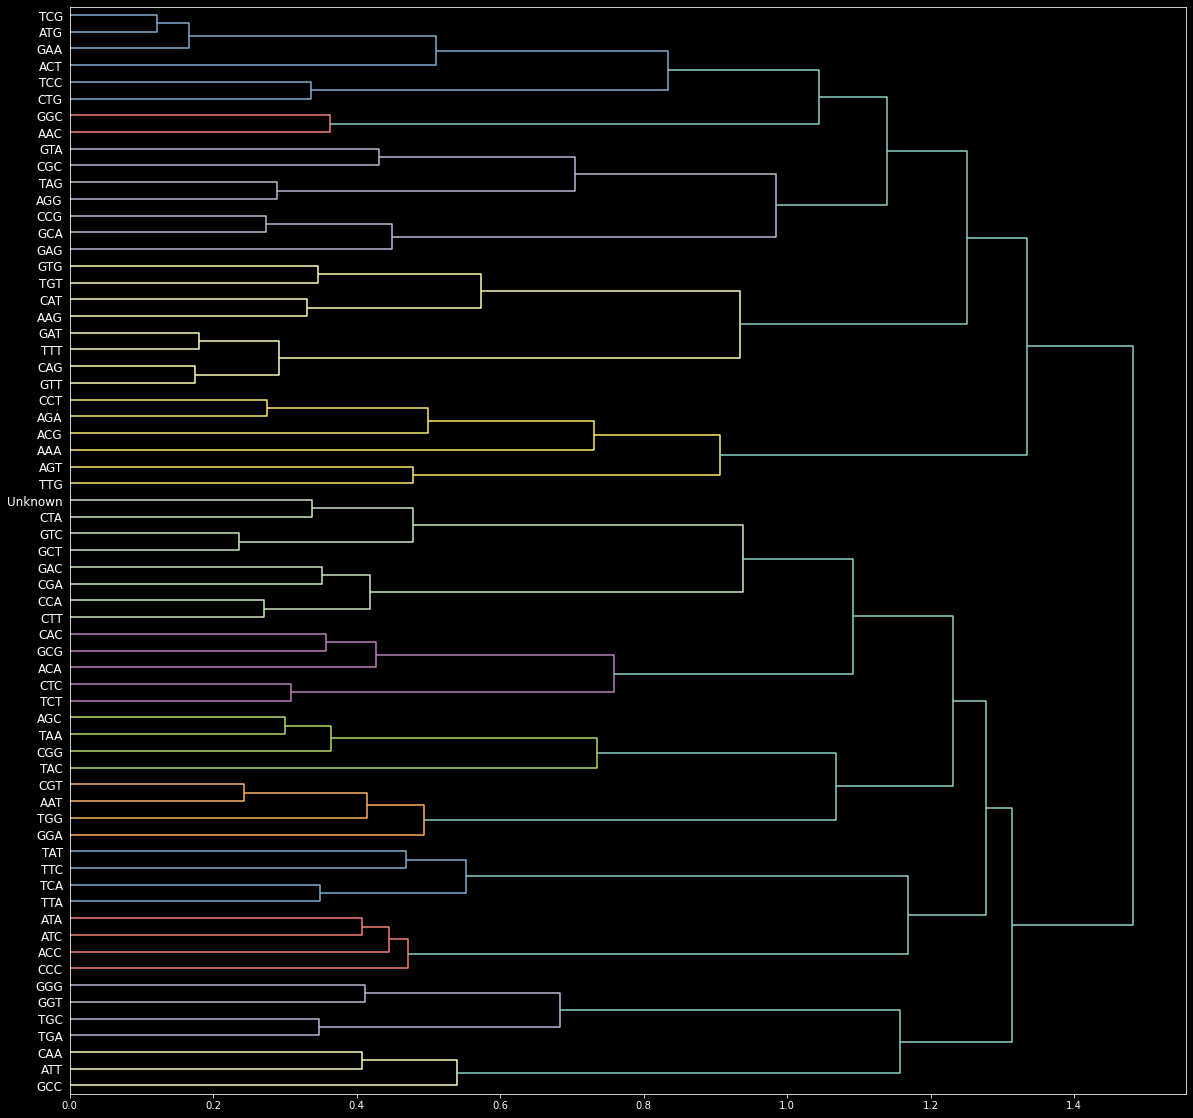

In [45]:
Z = linkage(embeddings, method='complete', metric='cosine')
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
labels = list(codon2codes.keys())
dn = dendrogram(
    Z, 
    truncate_mode=None, 
    orientation='right', 
    labels=labels, leaf_font_size=12,
    ax=ax
)
plt.show()

# Training with 500bp dataset

In [239]:
p2fasta = Path('../data/training_sequences_500bp.fasta').resolve()

sequences, encoded = preprocess_fasta(p2fasta, mode='both', max_nbr_seq=20)
assert len(sequences) == len(encoded)
len(encoded), len(encoded[0])

(20, 498)

In [240]:
max_nbr_seq = None

sequences, encoded = preprocess_fasta(p2fasta, mode='both', max_nbr_seq=max_nbr_seq)
len(sequences)

9000

In [241]:
targets, contexts, labels = generate_training_data(
    sequences=encoded,
    window_size=2,
    num_ns=4,
    vocab_size=vocab_size,
    seed=SEED)

targets = np.array(targets)
contexts = np.array(contexts)[:,:,0]
labels = np.array(labels)

print('\n')
print(f"targets.shape: {targets.shape}")
print(f"contexts.shape: {contexts.shape}")
print(f"labels.shape: {labels.shape}")

  0%|          | 0/9000 [00:00<?, ?it/s]



targets.shape: (518350,)
contexts.shape: (518350, 5)
labels.shape: (518350, 5)


In [243]:
vocab_size, embedding_dim, num_ns = len(code2codons), 20, 4

In [244]:
s2v = init_seq2vec(vocab_size, embedding_dim, num_ns)

opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

s2v.compile(
    optimizer=opt,
    loss=loss,
    metrics=['accuracy']
)

In [245]:
es = EarlyStopping(patience=10, monitor='loss', restore_best_weights=True, min_delta=1e-3)
pb = TqdmCallback(verbose=1)

hist = s2v.fit(
    dataset, 
    epochs=1000, 
    verbose=0,
    callbacks=[es, pb]
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

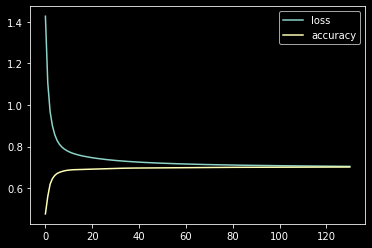

In [247]:
pd.DataFrame(hist.history).plot();

In [248]:
embeddings = s2v.get_layer('seq2vec_embs').get_weights()[0]
embeddings.shape

(65, 20)

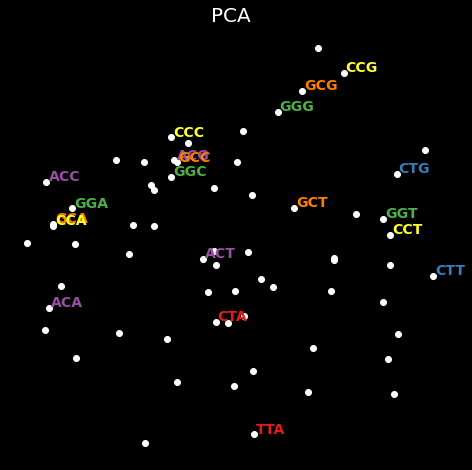

In [249]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
embs = pca.fit_transform(embeddings)

plot_embeddings(embs[:, 0], embs[:, 1], title='PCA')

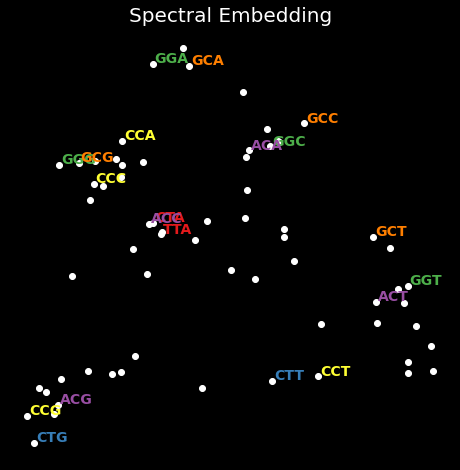

In [250]:
from sklearn.manifold import SpectralEmbedding
spectral = SpectralEmbedding(
    n_components=2,
    n_jobs=-1,
)
embs = spectral.fit_transform(embeddings)

plot_embeddings(embs[:, 0], embs[:, 1], title='Spectral Embedding')

/home/vtec/miniconda/envs/metagen/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


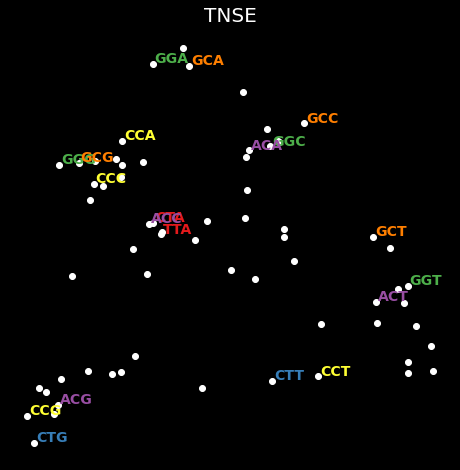

In [251]:
from sklearn.manifold import TSNE
tsne = TSNE(
    n_components=2,
    perplexity=20.0, 
    early_exaggeration=12.0,
    learning_rate='auto',
    n_iter=1000,
    init='pca',
    n_jobs=-1
    )

tsne_embs = tsne.fit_transform(embeddings)

plot_embeddings(embs[:, 0], embs[:, 1], title='TNSE')

In [252]:
targets, contexts, labels = generate_training_data(
    sequences=encoded,
    window_size=2,
    num_ns=15,
    vocab_size=vocab_size,
    seed=SEED)

targets = np.array(targets)
contexts = np.array(contexts)[:,:,0]
labels = np.array(labels)

print('\n')
print(f"targets.shape: {targets.shape}")
print(f"contexts.shape: {contexts.shape}")
print(f"labels.shape: {labels.shape}")

  0%|          | 0/9000 [00:00<?, ?it/s]



targets.shape: (517585,)
contexts.shape: (517585, 16)
labels.shape: (517585, 16)


In [253]:
vocab_size, embedding_dim, num_ns = len(code2codons), 20, 4

In [254]:
s2v = init_seq2vec(vocab_size, embedding_dim, num_ns)

opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

s2v.compile(
    optimizer=opt,
    loss=loss,
    metrics=['accuracy']
)

In [255]:
es = EarlyStopping(patience=10, monitor='loss', restore_best_weights=True, min_delta=1e-3)
pb = TqdmCallback(verbose=1)

hist = s2v.fit(
    dataset, 
    epochs=1000, 
    verbose=0,
    callbacks=[es, pb]
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

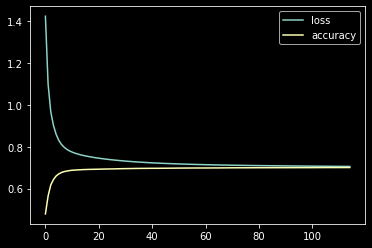

In [256]:
pd.DataFrame(hist.history).plot();

In [257]:
embeddings = s2v.get_layer('seq2vec_embs').get_weights()[0]
embeddings.shape

(65, 20)

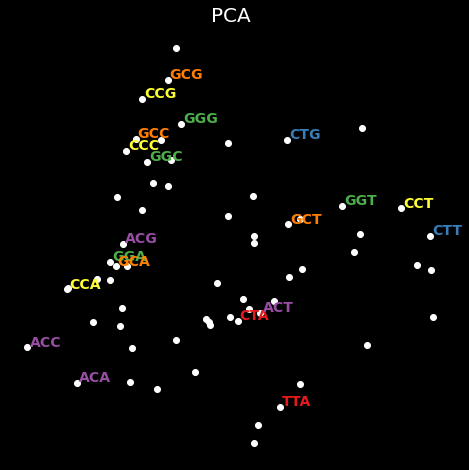

In [258]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
embs = pca.fit_transform(embeddings)

plot_embeddings(embs[:, 0], embs[:, 1], title='PCA')

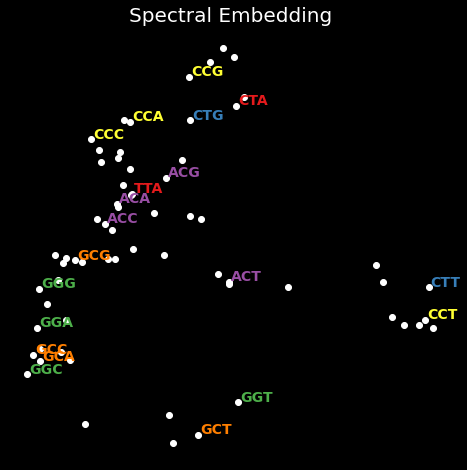

In [259]:
from sklearn.manifold import SpectralEmbedding
spectral = SpectralEmbedding(
    n_components=2,
    n_jobs=-1,
)

embs = spectral.fit_transform(embeddings)

plot_embeddings(embs[:, 0], embs[:, 1], title='Spectral Embedding')

/home/vtec/miniconda/envs/metagen/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


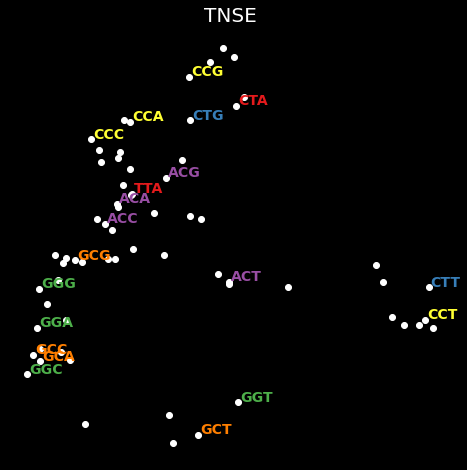

In [260]:
from sklearn.manifold import TSNE
tsne = TSNE(
    n_components=2,
    perplexity=20.0, 
    early_exaggeration=12.0,
    learning_rate='auto',
    n_iter=1000,
    init='pca',
    n_jobs=-1
    )

tsne_embs = tsne.fit_transform(embeddings)

plot_embeddings(embs[:, 0], embs[:, 1], title='TNSE')

https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html#module-scipy.cluster.hierarchy

https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html
https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html

In [42]:
from scipy.spatial.distance import pdist, cosine
from scipy.cluster.hierarchy import dendrogram, linkage

# cosine_distances = pdist(embeddings, cosine) # upper triangle of the distance matrix

In [401]:
codon_groups

{'Leucine': ['TTA', 'CTA'],
 'Group 2': ['CTG', 'CTT'],
 'Glycine': ['GGA', 'GGC', 'GGG', 'GGT'],
 'Threonine': ['ACA', 'ACC', 'ACG', 'ACT'],
 'Alanine': ['GCA', 'GCC', 'GCG', 'GCT'],
 'Proline': ['CCA', 'CCC', 'CCG', 'CCT']}

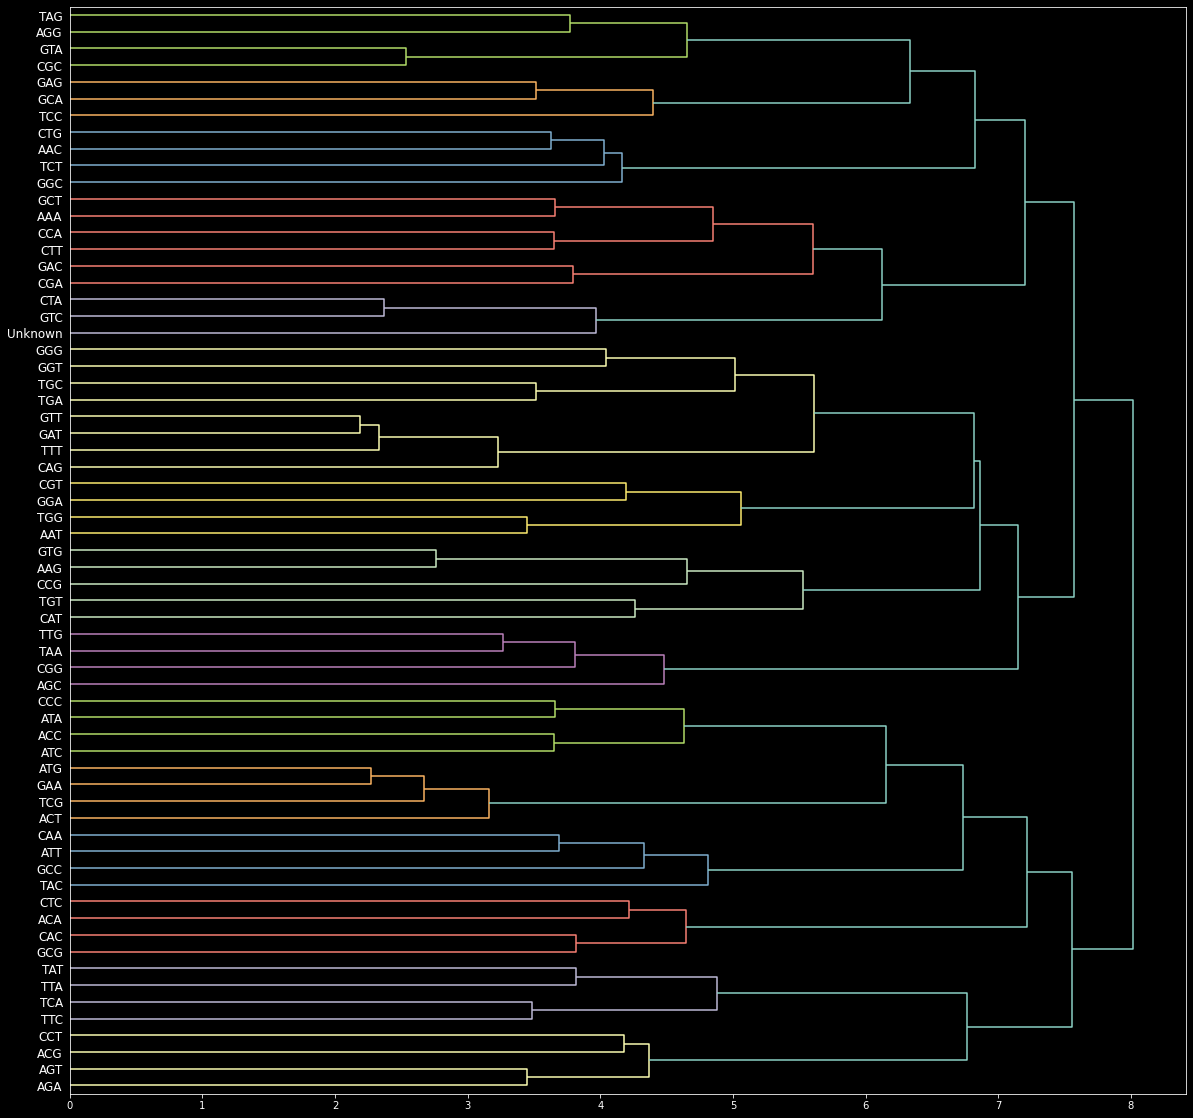

In [472]:
Z = linkage(embeddings, method='complete', metric='euclidean')
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
labels = list(codon2codes.keys())
dn = dendrogram(
    Z, 
    truncate_mode=None, 
    orientation='right', 
    labels=labels, leaf_font_size=12,
    ax=ax
)
plt.show()

In [478]:
display(dn['ivl'][:8])
print([codon2codes[c] for c in dn['ivl'][:8]])
display(dn['leaves'][:8])

['AGA', 'AGT', 'ACG', 'CCT', 'TTC', 'TCA', 'TTA', 'TAT']

[10, 49, 44, 59, 9, 15, 14, 16]


[9, 48, 43, 58, 8, 14, 13, 15]

In [483]:
print(len(Z))
[ (m, n, o, p)  for m,n,o,p in Z]

64


[(10.0, 21.0, 2.1906091204750977, 2.0),
 (2.0, 16.0, 2.2731597075957803, 2.0),
 (1.0, 65.0, 2.330227339333725, 3.0),
 (56.0, 60.0, 2.367466372957949, 2.0),
 (32.0, 51.0, 2.5333772462947928, 2.0),
 (35.0, 66.0, 2.6663537748422272, 3.0),
 (3.0, 52.0, 2.7610855160229004, 2.0),
 (46.0, 70.0, 3.161381640316746, 4.0),
 (25.0, 67.0, 3.22533354576375, 4.0),
 (12.0, 19.0, 3.268685346202575, 2.0),
 (9.0, 48.0, 3.443800445684704, 2.0),
 (4.0, 17.0, 3.4477277338355865, 2.0),
 (8.0, 14.0, 3.486185219321929, 2.0),
 (29.0, 50.0, 3.513809575604475, 2.0),
 (7.0, 42.0, 3.5179748774275725, 2.0),
 (11.0, 22.0, 3.6251982394133067, 2.0),
 (18.0, 36.0, 3.64896543072701, 2.0),
 (23.0, 41.0, 3.6536353136836417, 2.0),
 (0.0, 33.0, 3.6584831661527857, 2.0),
 (20.0, 63.0, 3.660929939983335, 2.0),
 (5.0, 6.0, 3.6863072768630825, 2.0),
 (53.0, 62.0, 3.7709322269758365, 2.0),
 (26.0, 39.0, 3.795391676056055, 2.0),
 (38.0, 74.0, 3.807220384059018, 3.0),
 (13.0, 15.0, 3.817155008495845, 2.0),
 (31.0, 55.0, 3.818552973

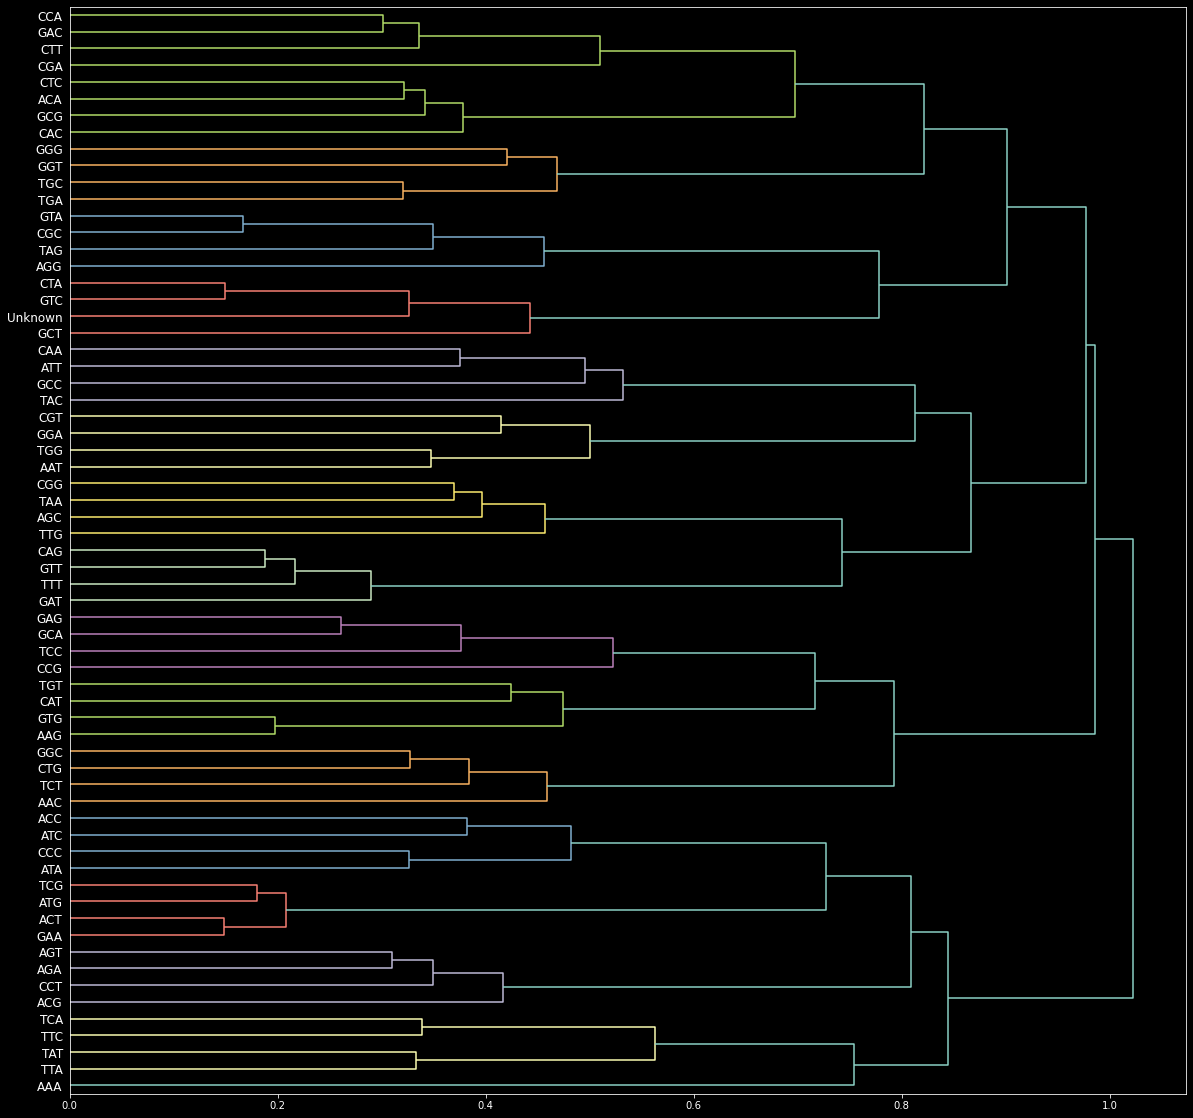

In [484]:
Z = linkage(embeddings[:, :], method='weighted', metric='cosine')
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
dn = dendrogram(
    Z, 
    truncate_mode=None, 
    orientation='right', 
    labels=df.index[:], leaf_font_size=12,
    ax=ax
)
plt.show()

In [486]:
key = 'ivl'
print(len(dn[key]))
dn[key][:5]

65


['AAA', 'TTA', 'TAT', 'TTC', 'TCA']

In [487]:
Z.shape

(64, 4)

In [491]:
Z[Z[:, 0] <= 65 , :]

array([[  2.        ,  46.        ,   0.14783307,   2.        ],
       [ 56.        ,  60.        ,   0.14933719,   2.        ],
       [ 32.        ,  51.        ,   0.16633701,   2.        ],
       [ 16.        ,  35.        ,   0.18042628,   2.        ],
       [ 21.        ,  25.        ,   0.18746681,   2.        ],
       [  3.        ,  52.        ,   0.1970431 ,   2.        ],
       [ 65.        ,  68.        ,   0.20816967,   4.        ],
       [  1.        ,  69.        ,   0.21622514,   3.        ],
       [ 29.        ,  50.        ,   0.26054643,   2.        ],
       [ 10.        ,  72.        ,   0.29006424,   4.        ],
       [ 39.        ,  41.        ,   0.30089458,   2.        ],
       [  9.        ,  48.        ,   0.30959096,   2.        ],
       [  7.        ,  42.        ,   0.31990173,   2.        ],
       [ 24.        ,  59.        ,   0.32175857,   2.        ],
       [ 20.        ,  63.        ,   0.32635747,   2.        ],
       [ 64.        ,  66